#  Compressible model
In this demo we show how to make a custom model e.g a compressible model. The default model in pulse is an incompressible model implemented using a two-field variational approach with Taylor-Hood finite elements. In this demo we use a pentaly-based compressible model where the term

$\kappa (J \mathrm{ln}J - J + 1)$

is added as a penalty to the strain energy denisty function, and we use $\mathbb{P}1$ elements for the displacement

In [14]:
# Imports
import matplotlib.pyplot as plt
import dolfin
import pulse
from pulse import (MechanicsProblem, DeformationGradient, Jacobian)

In [12]:
class CompressibleProblem(MechanicsProblem):
    """
    This class implements a compressbile model with a penalized
    compressibility term, solving for the displacement only.

    """
    def _init_spaces(self):

        mesh = self.geometry.mesh

        element = dolfin.VectorElement("P", mesh.ufl_cell(), 1)
        self.state_space = dolfin.FunctionSpace(mesh, element)
        self.state = dolfin.Function(self.state_space)
        self.state_test = dolfin.TestFunction(self.state_space)

        # Add penalty factor
        self.kappa = dolfin.Constant(1e3)

    def _init_forms(self):

        u = self.state
        v = self.state_test

        F = dolfin.variable(DeformationGradient(u))
        J = Jacobian(F)

        dx = self.geometry.dx

        # Add penalty term
        internal_energy = self.material.strain_energy(F) \
            + self.kappa * (J * dolfin.ln(J) - J + 1)

        self._virtual_work \
            = dolfin.derivative(internal_energy * dx,
                                self.state, self.state_test)

        self._virtual_work += self._external_work(u, v)

        self._jacobian \
            = dolfin.derivative(self._virtual_work, self.state,
                                dolfin.TrialFunction(self.state_space))

        self._set_dirichlet_bc()

2019-05-22 07:32:02,636 - pulse.geometry_utils - INFO - 
Load mesh from h5


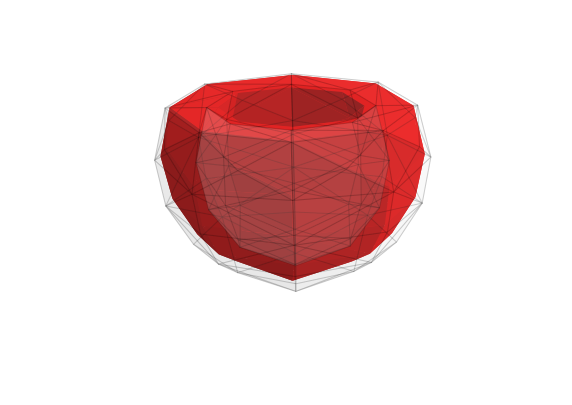

In [15]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (10,8)
geometry = pulse.Geometry.from_file(pulse.mesh_paths['simple_ellipsoid'])
# Plot geometry
# dolfin.plot(geometry.mesh, edgecolor="k", color="w")
# ax = plt.gca()
# ax.view_init(elev=-67, azim=-179)
# ax.set_axis_off()
# plt.show()

activation = dolfin.Function(dolfin.FunctionSpace(geometry.mesh, "R", 0))
activation.assign(dolfin.Constant(0.2))
matparams = pulse.HolzapfelOgden.default_parameters()
material = pulse.HolzapfelOgden(activation=activation,
                                parameters=matparams,
                                f0=geometry.f0,
                                s0=geometry.s0,
                                n0=geometry.n0)

# LV Pressure
lvp = dolfin.Constant(1.0)
lv_marker = geometry.markers['ENDO'][0]
lv_pressure = pulse.NeumannBC(traction=lvp,
                              marker=lv_marker, name='lv')
neumann_bc = [lv_pressure]

# Add spring term at the base with stiffness 1.0 kPa/cm^2
base_spring = 1.0
robin_bc = [pulse.RobinBC(value=dolfin.Constant(base_spring),
                          marker=geometry.markers["BASE"][0])]


# Fix the basal plane in the longitudinal direction
# 0 in V.sub(0) refers to x-direction, which is the longitudinal direction
def fix_basal_plane(W):
    V = W if W.sub(0).num_sub_spaces() == 0 else W.sub(0)
    bc = dolfin.DirichletBC(V.sub(0),
                            dolfin.Constant(0.0),
                            geometry.ffun, geometry.markers["BASE"][0])
    return bc


dirichlet_bc = [fix_basal_plane]
# You can also use a built in function for this
# from functools import partial
# dirichlet_bc = partial(pulse.mechanicsproblem.dirichlet_fix_base_directional,
#                        ffun=geometry.ffun,
#                        marker=geometry.markers["BASE"][0])

# Collect boundary conditions
bcs = pulse.BoundaryConditions(dirichlet=dirichlet_bc,
                               neumann=neumann_bc,
                               robin=robin_bc)

# Create the problem
problem = CompressibleProblem(geometry, material, bcs)

# Solve the problem
problem.solve()

# Get the solution
u = problem.state

# Move mesh accoring to displacement
mesh = dolfin.Mesh(geometry.mesh)
dolfin.ALE.move(mesh, u)

fig = plt.figure()
# Plot the result on to of the original
dolfin.plot(geometry.mesh, alpha=0.1, edgecolor='k', color='w')
dolfin.plot(mesh, color="r")

ax = plt.gca()
ax.view_init(elev=-67, azim=-179)
ax.set_axis_off()
plt.show()